In [1]:
from circuit_suite import circuits
# from backend_suite import backends, large_backends, shuffle_test, routing_test
#from backend_suite import placement_test

In [2]:
from backend_suite import backends
backends["Hatlab-Large-Riswap-Dense"].pass_manager.run(circuits["QFT"].circuit_lambda(4))

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)
/home/evm9/transpilation_EM/benchmark_suite/../utils/transpiler_passes/weyl_decompose.py:196: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(self.basis_gate)
/home/evm9/transpilation_EM/benchmark_suite/../utils/transpiler_passes/weyl_decompose.py:196: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(self.basis_gate)


## Circuit Transpile Benchmark

In [1]:
#make a plot :)
import matplotlib.pyplot as plt

def benchmark(backends, circuit_generator, q_range=None, continuously_save=False, overwrite=False):
    #override qrange if provided
    if q_range is None:
        q_range = circuit_generator.q_range
    
    #check if data dicts are empty
    for backend in backends:
        if not circuit_generator.label in backend.data.keys():
            backend.data[circuit_generator.label] = {}
            backend.data[circuit_generator.label]["duration"] = {}
            backend.data[circuit_generator.label]["gate_count"] = {}
            backend.data[circuit_generator.label]["gate_count_crit"] = {}
            backend.data[circuit_generator.label]["layout_score"] = {}

    #outer loop over circuit since this may take long time to generate
    for q in q_range:
        #create new variable sized lambda circuit
        qc = circuit_generator.circuit_lambda(q)

        for backend in backends:
            
            #condition to skip
            if not overwrite:
                #convert to int because if loaded from json key will be a string
                if q in [int(k) for k in backend.data[circuit_generator.label]["duration"].keys()]:
                    continue

            #logging.info(f"Transpiler qc{q} for {backend.label}")
            print(f"Transpiler qc{q} for {backend.label}")
            backend.pass_manager.run(qc)

            #save data to dict
            duration = backend.pass_manager.property_set["duration_longest_path_length"]
            backend.data[circuit_generator.label]["duration"][q] = float(duration)
            
            gate_count = backend.pass_manager.property_set["count_ops"]
            backend.data[circuit_generator.label]["gate_count"][q] = gate_count

            #FIXME
            # gate_count_critical_path = backend.pass_manager.property_set["count_ops_longest_path"]
            # backend.data[circuit_generator.label]["gate_count_crit"][q] = gate_count_critical_path

            layout_score = backend.pass_manager.property_set["layout_score"]
            backend.data[circuit_generator.label]["layout_score"][q] = float(layout_score)

            #for long tests, may want to save more regularly in case exit early
            if continuously_save:
                backend.save_json()
                
    for backend in backends:
        #save dict to json
        backend.save_json()

In [2]:
#FIXME, use figure to handle subplots
def plot(backends, circuit_label, parameter="duration"):
    for backend in backends:
        if circuit_label in backend.data.keys():
            x = backend.data[circuit_label][parameter].keys()
            x = [int(el) for el in list(x)]
            y = backend.data[circuit_label][parameter].values()
            x, y = zip(*sorted(zip(x, y)))
            plt.plot(x, y, '-o', label=backend.label)

    plt.xlabel(circuit_label)
    plt.ylabel("circuit duration")
    plt.legend()

    #savefig
    filename = f"images/large_{circuit_label}_{parameter}"
    import os
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
        i += 1
    plt.savefig('{}{:d}.png'.format(filename, i), facecolor='white')

#plot(placement_test, circuit_gen.label, parameter="duration")
#plot(routing_test, circuit_gen.label, parameter="layout_score")

/home/evm9/transpilation_EM/venv/lib/python3.8/site-packages/qiskit/transpiler/passes/optimization/consolidate_blocks.py:55: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(kak_basis_gate)


Transpiler qc80 for Hatlab-Large-Riswap-Upgrade


/home/evm9/transpilation_EM/benchmark_suite/../utils/transpiler_passes/weyl_decompose.py:196: UserWarning: Only know how to decompose properly for supercontrolled basis gate. This gate is ~Ud(0.3926990816987239, 0.3926990816987239, 0.0)
  self.decomposer = TwoQubitBasisDecomposer(self.basis_gate)


Transpiler qc80 for Heavy-Hex


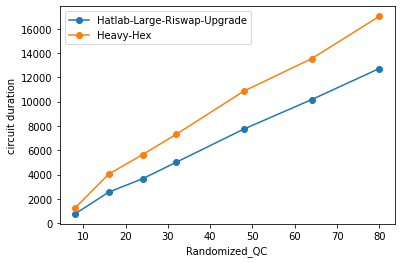

In [3]:
from circuit_suite import circuits
circuit_gen = circuits["Randomized_QC"]
from backend_suite import new_test
#with critical path turned off
benchmark(backends=new_test, circuit_generator=circuit_gen, continuously_save=True)
#plot(placement_test, circuit_gen.label, parameter="duration")
plot(new_test, circuit_gen.label, parameter="duration")

Important data- note that the hypercube inserts more swaps than hatlab (172 vs 119), therefore decomposes to more riswaps (1094 vs 935); however, in the critical path hypercube now has less riswaps than hatlab (402 vs 435). This means that more of the swaps that are happening the in the hypercube are parallizable? Suggests better placement and routing algorithms are still needed - problem is that they become very slow. Except, Hatlab has a better layout score? That must mean that BasicSwapPass is just really bad?

In [ ]:
#with critical path turned on
circuit_gen = circuits["TIM_Hamiltonian"]
benchmark(backends=[backends["Hypercube-Large-Riswap"], backends["Hatlab-Large-Riswap"]], circuit_generator=circuit_gen, q_range=[30])

In [ ]:
circuit_gen = circuits["QAOA_Vanilla"]
backends = shuffle_test
benchmark(backends=backends, circuit_generator=circuit_gen)

In [ ]:
circuit_gen = circuits["QFT"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

In [ ]:
circuit_gen = circuits["Randomized_QC"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

In [ ]:
circuit_gen = circuits["GHZ"]
benchmark(backends=large_backends, circuit_generator=circuit_gen)

In [ ]:
circuit_gen = circuits["VQE"]
benchmark(backends=large_backends, circuit_generator=circuit_gen, q_range=[8, 16, 32])